# Qual é o perfil de quem assina o cartola?



## outliers

Estratégia:
* Verificamos que: entre os dados faltantes

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
df_raw = pd.read_csv("./data/raw/ge_df_users_editorias_02.csv")
df_raw.info()
treated_df = df_raw.copy()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50689 entries, 0 to 50688
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   user                  50689 non-null  int64  
 1   sexo                  22440 non-null  object 
 2   uf                    21559 non-null  object 
 3   idade                 22616 non-null  float64
 4   dias                  50689 non-null  int64  
 5   pviews                50689 non-null  int64  
 6   visitas               50689 non-null  int64  
 7   tempo_total           50689 non-null  float64
 8   device                50689 non-null  object 
 9   futebol               50689 non-null  float64
 10  futebol_intenacional  50689 non-null  float64
 11  futebol_olimpico      50689 non-null  float64
 12  blog_cartola          50689 non-null  float64
 13  atletismo             50689 non-null  float64
 14  ginastica             50689 non-null  float64
 15  judo               

In [2]:
from sklearn.ensemble import IsolationForest

outliers_measuring = df_raw.copy().dropna()
features_columns = [c for c in outliers_measuring.columns if c not in ('user', 'sexo', 'uf', 'cartola_status','device')]

# Uso do algoritmo de Isolation Forest para detecção da quantidade de outliers
clf = IsolationForest(
    random_state=42,
    contamination='auto',
    n_jobs=-1
)

preds = clf.fit_predict(outliers_measuring[features_columns].values)

print("Porcentagem de outliers na base: %.2f%%" % ((list(preds).count(-1) / outliers_measuring.shape[0]) * 100))


Porcentagem de outliers na base: 6.89%


In [3]:
import pandas as pd
import missingno as msno 

missing_analysis_df = df_raw.copy()

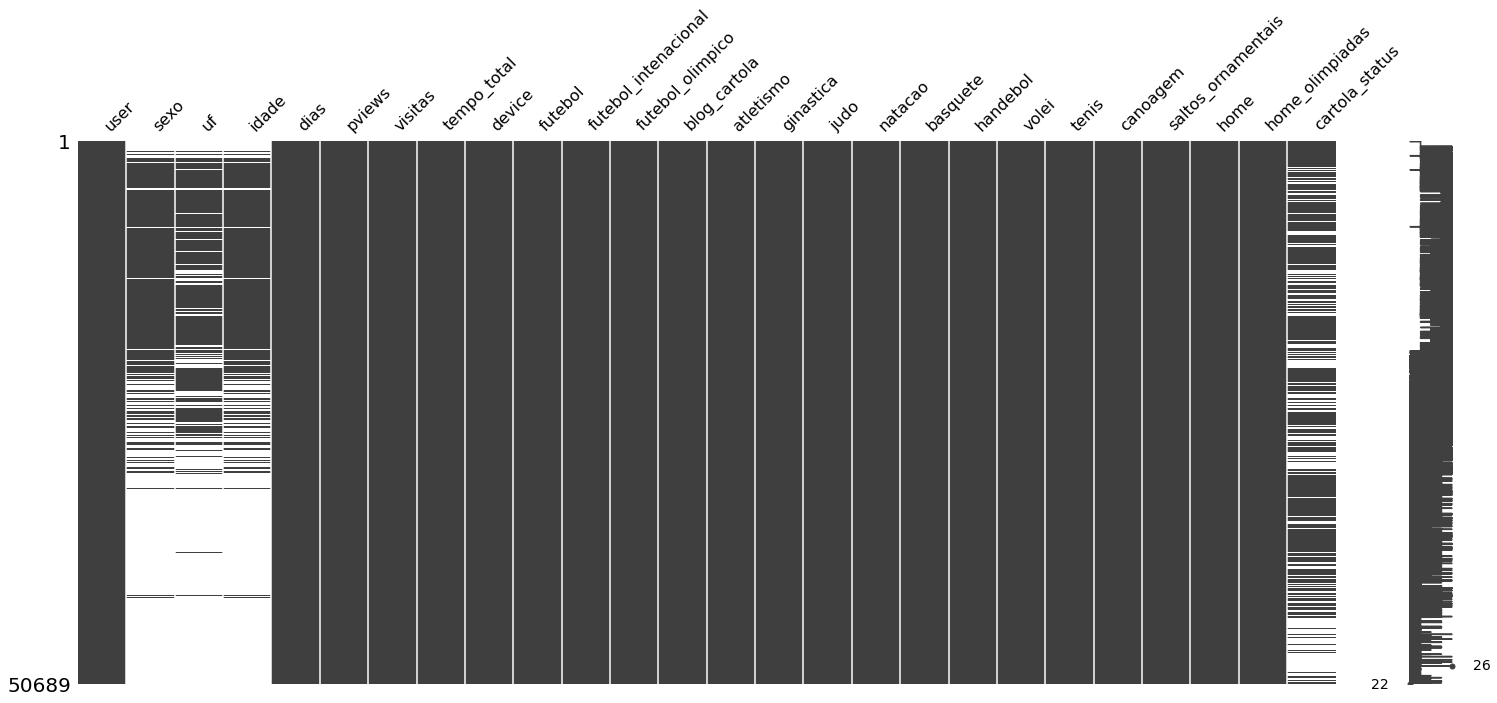

In [4]:
msno.matrix(missing_analysis_df)

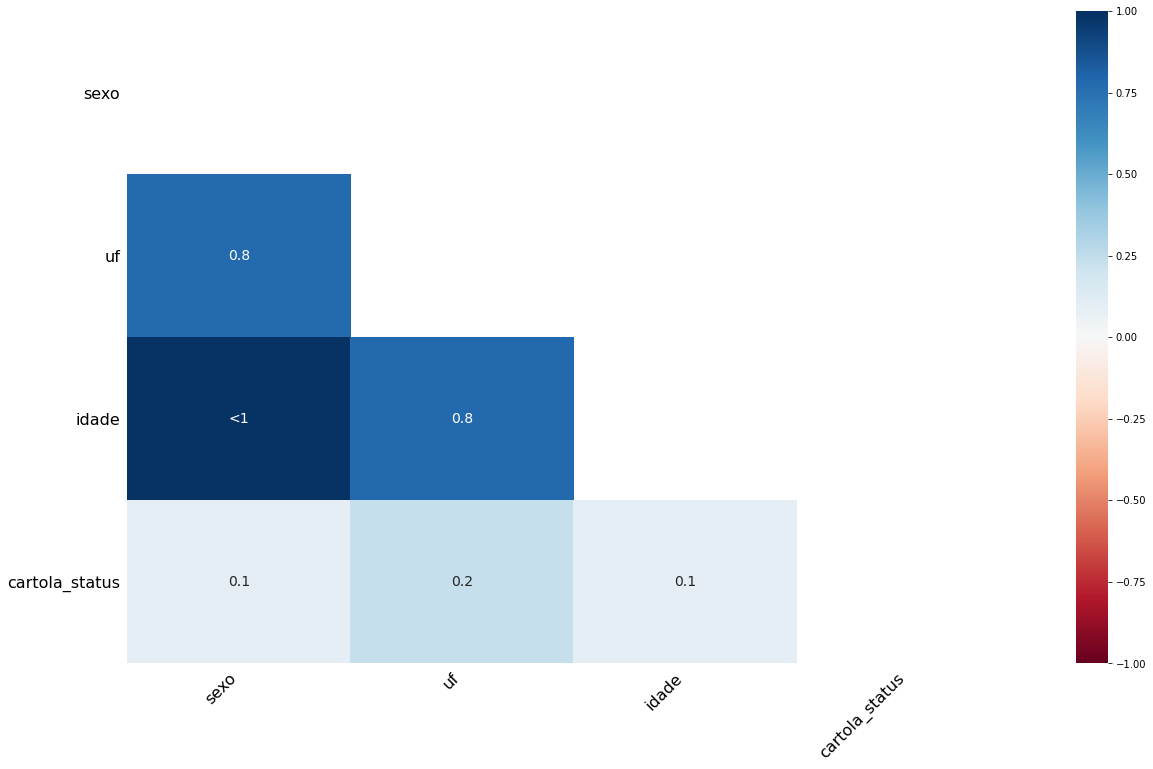

In [5]:

msno.heatmap(missing_analysis_df) 

### Consideraçoes
* Aparentemente existe a possibilidade de se cadastrar sem informar dados pessoais como gênero, sexo e idade.
* Existe forte correlação entre quem escolhe não informar um desses campos, não informar os outros dois.
* A princípio não é um problema, podemos tentar inferir o sexo baseado no comportamento no aplicativo ou tratar como se existissem 3 tipos. 
* Antes de iniciar qualquer possível tratamento desses tipos, vamos ver qual é a importância de M e F num modelo simples.


Vamos dar labels para as colunas com variáveis categóricas

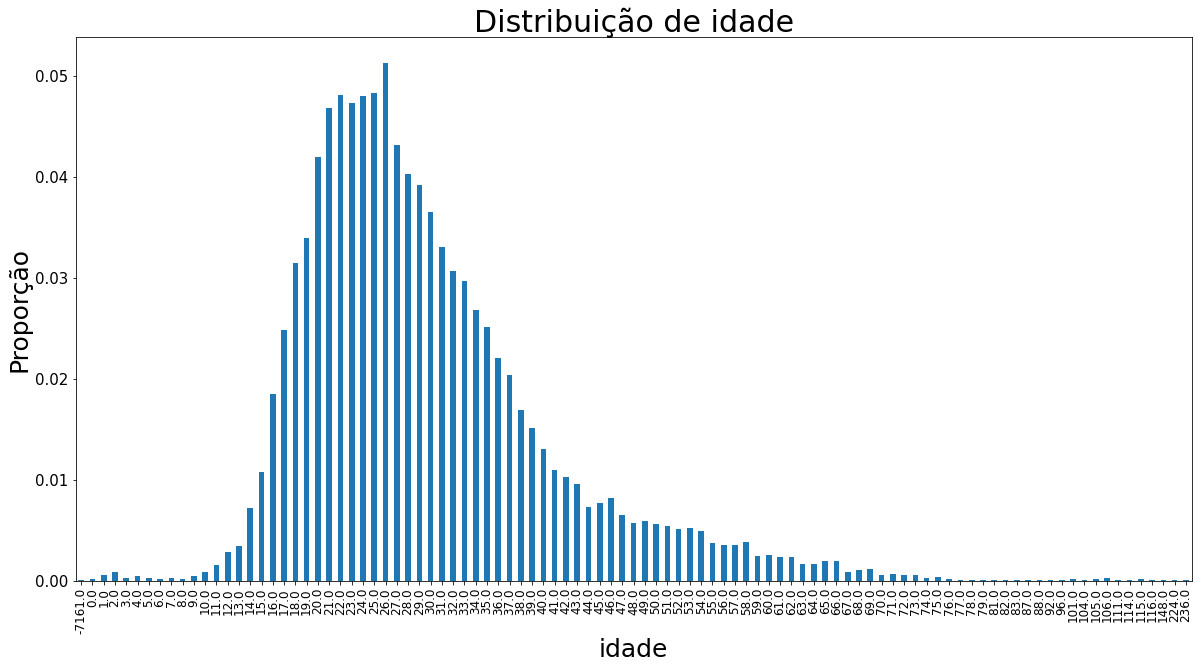

In [6]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.title('Distribuição de idade', fontsize = 30)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 15)
plt.ylabel('Proporção', fontsize = 25)
plt.xlabel('idade', fontsize = 25)
df_raw.idade.value_counts(sort = True, normalize = True).sort_index().plot(kind='bar')


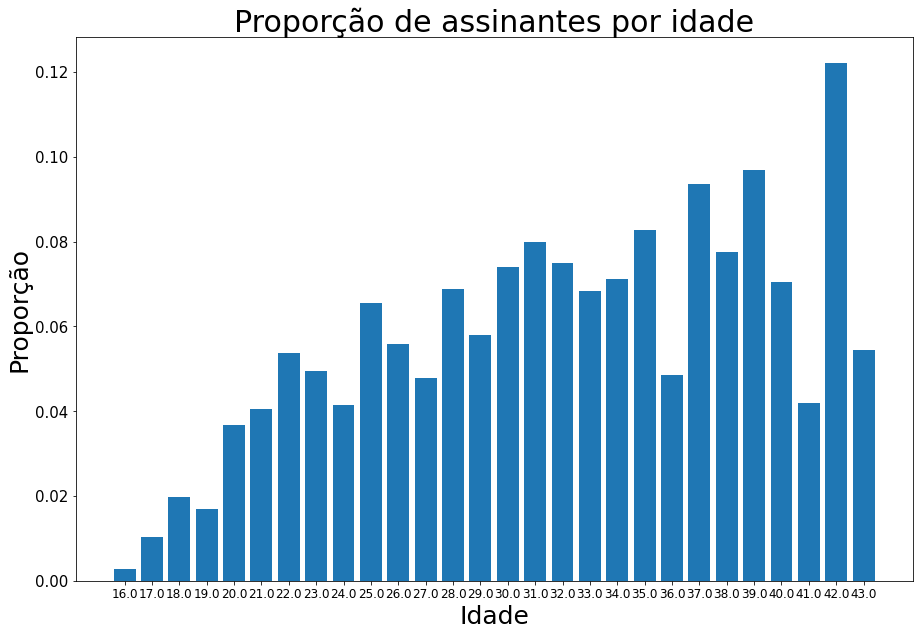

In [7]:
#relação entre idade e assinantes considerando a proporção de cada idade
assinantes = df_raw[df_raw['cartola_status']=='Cartola Pro'].idade.value_counts(sort = True).sort_index().to_dict()
df_prop_idade = df_raw[df_raw['cartola_status'].isna()==False]
df_prop_idade = df_prop_idade[df_prop_idade['cartola_status']!='Não Cartola']
total = df_prop_idade.idade.value_counts(sort = True).sort_index().to_dict()

prop_idade_assinantes = dict()
for key in assinantes.keys():
    if total[key]>100:
        prop_idade_assinantes[key] = assinantes[key]/total[key]


fig, ax = plt.subplots(figsize=(15, 10))
plt.title('Proporção de assinantes por idade', fontsize = 30)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 15)
plt.ylabel('Proporção', fontsize = 25)
plt.xlabel('Idade', fontsize = 25)
plt.bar(range(len(prop_idade_assinantes)), list(prop_idade_assinantes.values()), align='center')
plt.xticks(range(len(prop_idade_assinantes)), list(prop_idade_assinantes.keys()))

plt.show()

In [8]:
import numpy as np
#Gerarando um sample que corresponda aos dados faltantes na idade e que leve em consideração a distribuição
distribution_prob = df_raw[df_raw['idade'].between(10, 90, inclusive=True)].idade.value_counts(sort = True, normalize = True).tolist()
possible_ages = df_raw[df_raw['idade'].between(10, 90, inclusive=True)].idade.value_counts(sort = True, normalize = True).keys().tolist()
possible_ages = [int(x) for x in possible_ages]
ages = list()

#Aplicando a distribuição somente onde houver dado faltante ou outlier
for item in df_raw.itertuples():
    if (10<item.idade<90):
        ages.append(int(item.idade))
    else:
        ages.append(np.random.choice(possible_ages,1,p=distribution_prob)[0])
        
# Movendo a lista para o dataset 
df_age_fixed = df_raw.copy()
df_age_fixed['idade'] = ages
treated_df['idade'] = df_age_fixed.idade.values

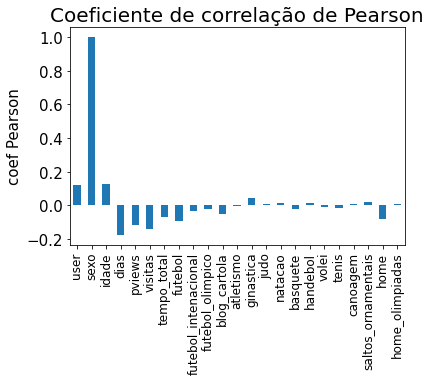

In [9]:
#Vamos ver se o sexo tem correlação linear com algum comportamento

df_sex = df_age_fixed.copy()
df_sex['sexo'] = df_sex.sexo.replace('M', -1)
df_sex['sexo'] = df_sex.sexo.replace('F', 1)
corr = df_sex.corr()
corr['sexo'].plot(kind = 'bar')
plt.title('Coeficiente de correlação de Pearson', fontsize = 20)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 15)
plt.ylabel('coef Pearson', fontsize = 15)
plt.show()

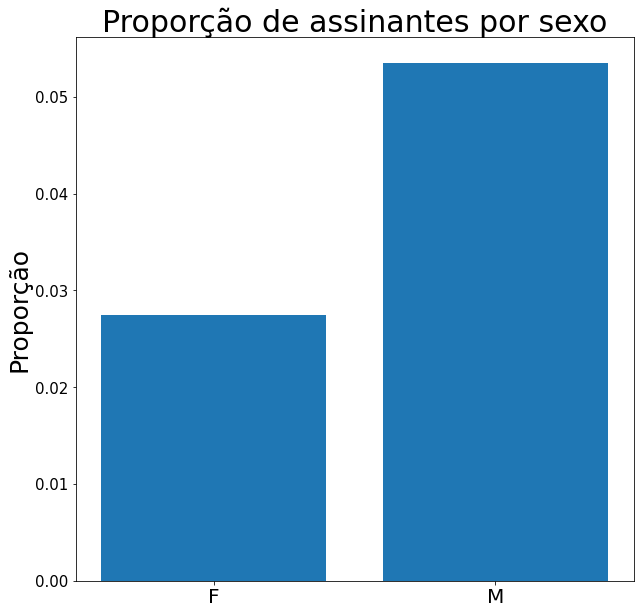

In [10]:
#relação entre sexo e assinantes considerando a proporção de cada idade
assinantes = df_raw[df_raw['cartola_status']=='Cartola Pro'].sexo.value_counts(sort = True).sort_index().to_dict()
df_prop_sexo = df_raw[df_raw['cartola_status'].isna()==False]
df_prop_sexo = df_prop_sexo[df_prop_sexo['cartola_status']!='Não Cartola']
total = df_prop_sexo.sexo.value_counts(sort = True).sort_index().to_dict()

prop_sexo_assinantes = dict()
for key in assinantes.keys():
    if total[key]>100:
        prop_sexo_assinantes[key] = assinantes[key]/total[key]

fig, ax = plt.subplots(figsize=(10, 10))
plt.xticks(range(len(prop_sexo_assinantes)), list(prop_sexo_assinantes.keys()))
plt.title('Proporção de assinantes por sexo', fontsize = 30)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 15)
plt.ylabel('Proporção', fontsize = 25)
plt.bar(range(len(prop_sexo_assinantes)), list(prop_sexo_assinantes.values()), align='center')
plt.show()



In [11]:
from sklearn.preprocessing import PowerTransformer
features_labels = [c for c in df_sex.columns if c not in ['uf','user', 'sexo']]
df_sex_model_data = pd.get_dummies(df_sex[features_labels].dropna(), prefix_sep='_', drop_first=False, dtype='int8')

# Uso do PowerTransformer por conta dos outliers vistos na análise do dataset
scaler = PowerTransformer()
scaler.fit(df_sex_model_data.values)

# Aplicação da transformação no dataset
df_sex_model_data[df_sex_model_data.columns] = scaler.transform(df_sex_model_data.values)
df_sex_model_data['sexo'] = df_sex.sexo
df_sex_model_data = df_sex_model_data.dropna()

/home/luiz/Documentos/processos/globo/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/luiz/Documentos/processos/globo/venv/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


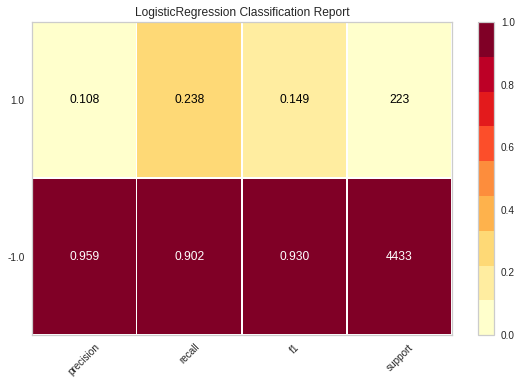

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from yellowbrick.classifier import ClassificationReport

X = df_sex_model_data.iloc[:,0:-1]
Y = df_sex_model_data.iloc[:,-1]


X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
dist = {-1 : 0.09, 1 : 0.91}

logreg = LogisticRegression(solver = 'newton-cg', class_weight = dist, n_jobs=-1)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

visualizer = ClassificationReport(logreg, support=True)

visualizer.fit(X_train, y_train)        # Fit the visualizer and the model
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show() 

#Um pouco melhor do que simplesmente usarmos a distribuição

In [13]:
df_sex_predictor = pd.get_dummies(df_sex[features_labels], prefix_sep='_', drop_first=False, dtype='int8')
df_sex_predictor[df_sex_predictor.columns] = scaler.transform(df_sex_predictor.values)
df_sex_predictor['sexo'] = df_raw['sexo'].values

raw_sex_list = list()
for i,item in enumerate(df_sex_predictor.itertuples(),0):
    if item.sexo==1 or item.sexo==-1:
        raw_sex_list.append(int(item.sexo))
    else:
        raw_sex_list.append(int(logreg.predict(np.array(df_sex_predictor.iloc[i,0:-1]).reshape(1, -1))[0]))
df_sex_predictor['sexo'] = raw_sex_list
treated_df['sexo'] = raw_sex_list

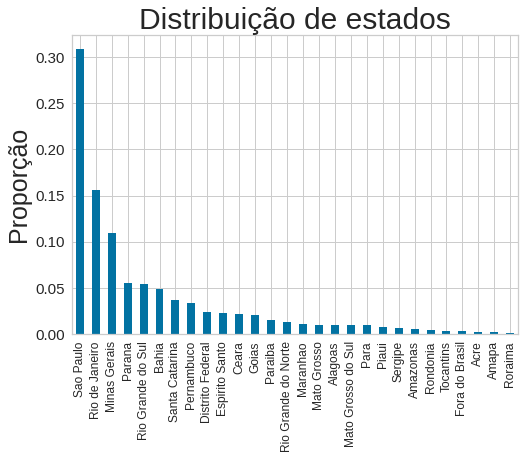

In [14]:
plt.title('Distribuição de estados', fontsize = 30)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 15)
plt.ylabel('Proporção', fontsize = 25)
df_raw.uf.value_counts(normalize=True).plot(kind='bar')



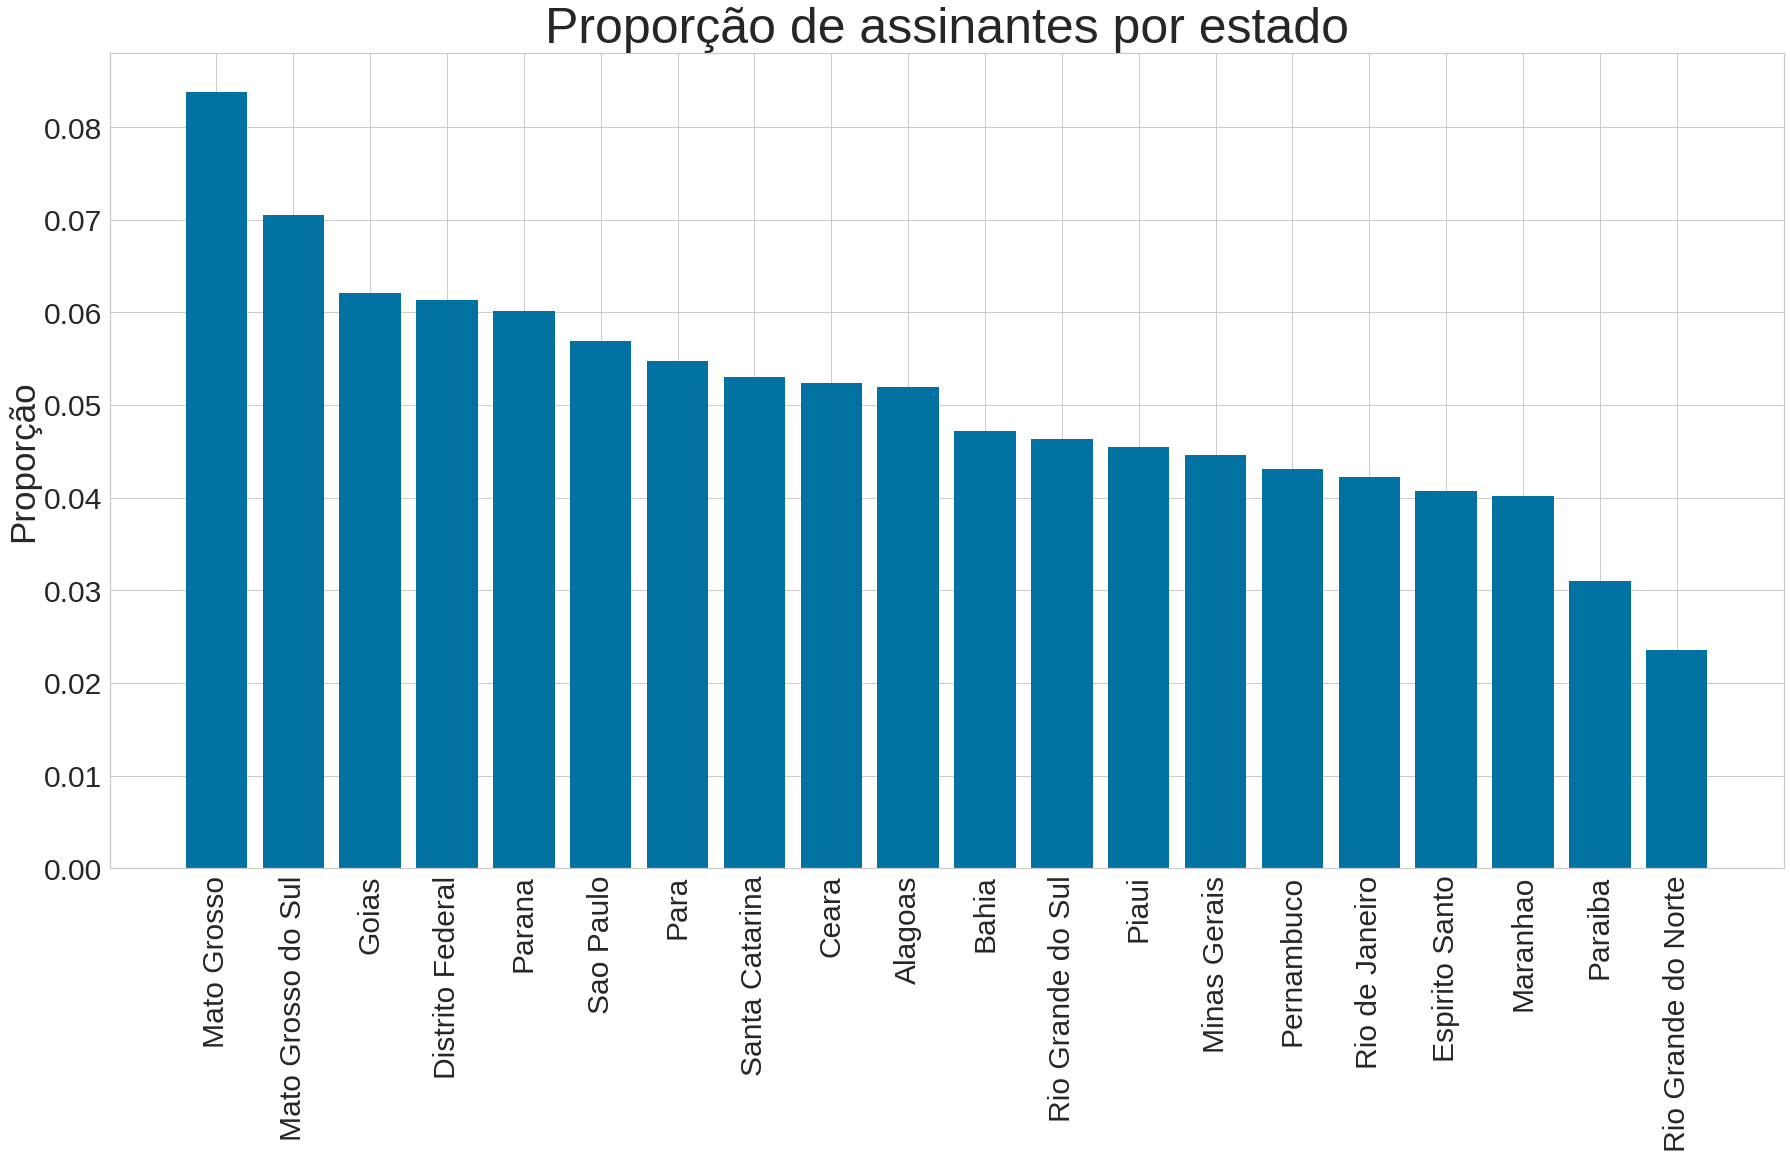

In [15]:
#relação entre o estado e assinantes considerando a proporção de cada estado
assinantes = df_raw[df_raw['cartola_status']=='Cartola Pro'].uf.value_counts(sort = True).sort_index().to_dict()
df_prop_uf = df_raw[df_raw['cartola_status'].isna()==False]
df_prop_uf = df_prop_uf[df_prop_uf['cartola_status']!='Não Cartola']
total = df_prop_uf.uf.value_counts(sort = True).sort_index().to_dict()

prop_uf_assinantes = dict()
for key in assinantes.keys():
    if total[key]>100:
        prop_uf_assinantes[key] = assinantes[key]/total[key]
prop_uf_assinantes = {k: v for k, v in sorted(prop_uf_assinantes.items(), key=lambda item: item[1], reverse = True)}

fig, ax = plt.subplots(figsize=(30, 15))

plt.bar(range(len(prop_uf_assinantes)), list(prop_uf_assinantes.values()), align='center')
plt.xticks(range(len(prop_uf_assinantes)), list(prop_uf_assinantes.keys()), fontsize=30, rotation = 'vertical')
plt.yticks(fontsize=25)
plt.title('Proporção de assinantes por estado', fontsize = 50)
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 30)
plt.ylabel('Proporção', fontsize = 35)



plt.show()

O sudeste soma quase 60% dos dados

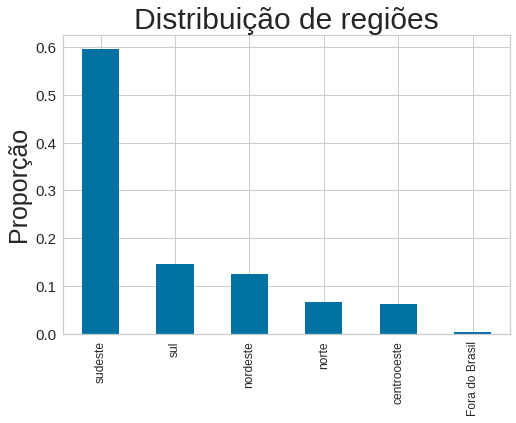

In [16]:
#Vamos separar essa coluna em sudeste, sul e então outros
SUDESTE = ['Sao Paulo', 'Minas Gerais', 'Rio de Janeiro', 'Espirito Santo']
SUL = ['Parana', 'Rio Grande do Sul', 'Santa Catarina']
NORDESTE = ['Bahia', 'Paraiba','Rio Grande do Norte' 'Maranhao', 'Pernambuco','Ceara', 'Sergipe']
CENTROOESTE = ['Mato Grosso', 'Mato Grosso do Sul', 'Distrito Federal', 'Goias']
NORTE = [s for s in df_raw.uf.value_counts().keys() if s not in SUDESTE and s not in SUL and s not in NORDESTE and s not in CENTROOESTE and s!='Fora do Brasil']

df_uf = df_raw.copy()
for i, item in enumerate(df_raw.itertuples(),0):
    if item.uf in SUDESTE:
        df_uf.iloc[i, 2] = 'sudeste'
    if item.uf in SUL:
        df_uf.iloc[i, 2] = 'sul'
    if item.uf in NORDESTE:
        df_uf.iloc[i, 2] = 'nordeste'
    if item.uf in CENTROOESTE:
        df_uf.iloc[i, 2] = 'centrooeste'
    if item.uf in NORTE:
        df_uf.iloc[i, 2] = 'norte'
    else: pass
    
plt.title('Distribuição de regiões', fontsize = 30)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 15)
plt.ylabel('Proporção', fontsize = 25)
df_uf.uf.value_counts(normalize=True).plot(kind='bar')


    

In [17]:
regions = df_uf.uf.value_counts(normalize=True).keys().to_list()
prob_regions = df_uf.uf.value_counts(normalize=True).to_list()

regs = list()

#Aplicando a distribuição somente onde houver dado faltante ou outlier
for item in df_uf.itertuples():
    if str(item.uf)!='nan':
        regs.append(item.uf)
    else:
        regs.append(np.random.choice(regions,1,p=prob_regions)[0])
        
df_uf['uf'] = regs
treated_df['uf'] = regs
treated_df_bckp = treated_df.copy()

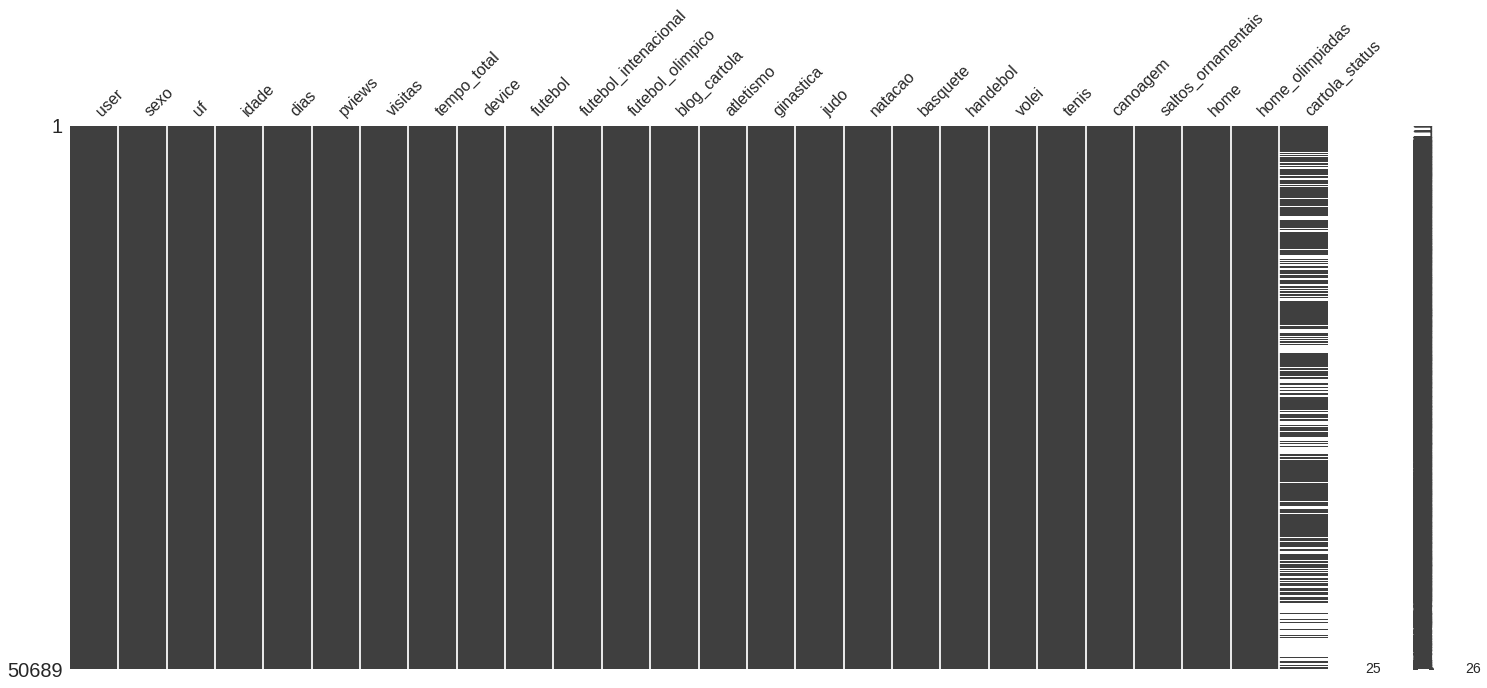

In [18]:
msno.matrix(treated_df)


In [19]:
treated_df = treated_df_bckp.dropna()
treated_df = pd.get_dummies(treated_df[treated_df['cartola_status']!='Não Cartola'], prefix_sep='_', drop_first=False, dtype='int8')
filter_columns = [x for x in treated_df.columns if x!='user' and x!='cartola_status_Cartola Free']
treated_df = treated_df[filter_columns]
treated_df

,sexo,idade,dias,pviews,visitas,tempo_total,futebol,futebol_intenacional,futebol_olimpico,blog_cartola,...,uf_Fora do Brasil,uf_centrooeste,uf_nordeste,uf_norte,uf_sudeste,uf_sul,device_m_only,device_pc_e_m,device_pc_only,cartola_status_Cartola Pro
3,1,36,1,1,1,45.000,0.000,0.0,0.000,45.000,...,0,0,0,0,1,0,1,0,0,0
25,-1,24,7,66,10,3667.527,2992.077,0.0,289.701,245.240,...,0,0,0,0,1,0,0,1,0,1
31,1,25,7,14,6,4657.538,0.000,0.0,0.000,45.000,...,0,0,0,0,1,0,0,1,0,0
34,-1,24,8,49,24,7184.887,911.353,0.0,376.346,47.171,...,0,0,0,0,1,0,0,0,1,0
43,-1,31,21,75,46,10243.229,140.360,0.0,1068.097,95.125,...,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50680,-1,30,1,6,1,196.213,45.000,0.0,0.000,0.000,...,0,0,0,0,1,0,0,0,1,0
50681,1,45,1,2,1,47.328,0.000,0.0,0.000,47.328,...,0,0,0,0,1,0,0,0,1,0
50683,1,29,1,2,1,47.364,0.000,0.0,0.000,47.364,...,0,0,0,0,1,0,0,0,1,0
50684,-1,20,1,2,1,47.166,0.000,0.0,0.000,47.166,...,0,0,0,0,1,0,1,0,0,0


In [20]:
from sklearn.preprocessing import PowerTransformer

# Uso do PowerTransformer por conta dos outliers vistos na análise do dataset
columns = [c for c in treated_df.columns if not c.startswith('cartola_status')]
scaler = PowerTransformer()
scaler.fit(treated_df[columns].values)

# Aplicação da transformação no dataset
treated_df[columns] = scaler.transform(treated_df[columns].values)
treated_df



,sexo,idade,dias,pviews,visitas,tempo_total,futebol,futebol_intenacional,futebol_olimpico,blog_cartola,...,uf_Fora do Brasil,uf_centrooeste,uf_nordeste,uf_norte,uf_sudeste,uf_sul,device_m_only,device_pc_e_m,device_pc_only,cartola_status_Cartola Pro
3,2.383396,0.910988,-1.458857,-1.649564,-1.478783,-1.582852,-1.341881,-0.583558,-0.777990,-0.310971,...,-0.051626,-0.254223,-0.380601,-0.269935,0.822138,-0.412646,1.304367,-0.630147,-0.726707,0
25,-0.419569,-0.325194,0.051404,0.748166,0.101773,0.342635,0.781043,-0.583558,1.260677,0.280678,...,-0.051626,-0.254223,-0.380601,-0.269935,0.822138,-0.412646,-0.766655,1.586932,-0.726707,1
31,2.383396,-0.193489,0.051404,-0.191602,-0.286001,0.445764,-1.341881,-0.583558,-0.777990,-0.310971,...,-0.051626,-0.254223,-0.380601,-0.269935,0.822138,-0.412646,-0.766655,1.586932,-0.726707,0
34,-0.419569,-0.325194,0.182849,0.573188,0.754010,0.632352,0.412995,-0.583558,1.298782,-0.295429,...,-0.051626,-0.254223,-0.380601,-0.269935,0.822138,-0.412646,-0.766655,-0.630147,1.376070,0
43,-0.419569,0.473496,1.196725,0.822262,1.213194,0.784527,-0.124567,-0.583558,1.426689,-0.057787,...,-0.051626,-0.254223,-0.380601,-0.269935,0.822138,-0.412646,-0.766655,1.586932,-0.726707,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50680,-0.419569,0.374726,-1.458857,-0.715472,-1.478783,-0.935291,-0.426079,-0.583558,-0.777990,-1.472637,...,-0.051626,-0.254223,-0.380601,-0.269935,0.822138,-0.412646,-0.766655,-0.630147,1.376070,0
50681,2.383396,1.525508,-1.458857,-1.336871,-1.478783,-1.560766,-1.341881,-0.583558,-0.777990,-0.294331,...,-0.051626,-0.254223,-0.380601,-0.269935,0.822138,-0.412646,-0.766655,-0.630147,1.376070,0
50683,2.383396,0.271520,-1.458857,-1.336871,-1.478783,-1.560433,-1.341881,-0.583558,-0.777990,-0.294080,...,-0.051626,-0.254223,-0.380601,-0.269935,0.822138,-0.412646,-0.766655,-0.630147,1.376070,0
50684,-0.419569,-0.933821,-1.458857,-1.336871,-1.478783,-1.562268,-1.341881,-0.583558,-0.777990,-0.295464,...,-0.051626,-0.254223,-0.380601,-0.269935,0.822138,-0.412646,1.304367,-0.630147,-0.726707,0


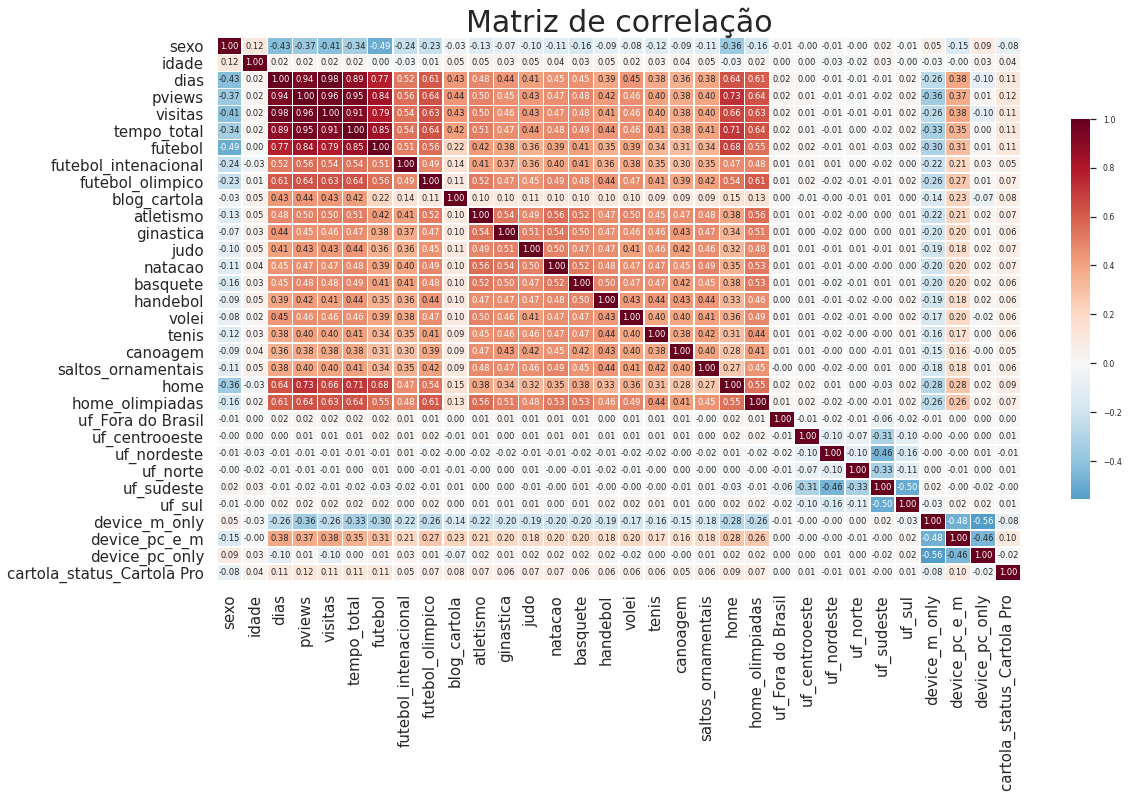

In [21]:
import numpy as np
import seaborn as sns
sns.set(font_scale=0.7) 
fig, ax = plt.subplots(figsize=(18, 10))
sns.heatmap(
    treated_df.corr(),
    vmax=1.0,
    center=0,
    fmt='.2f',
    annot=True,
    square=False,
    linewidths=.5,
    cbar_kws={"shrink": .70},
    cmap="RdBu_r"
)
plt.title('Matriz de correlação', fontsize = 30)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

plt.show()

In [ ]:
from xgboost import XGBClassifier
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ROCAUC
from bayes_opt import BayesianOptimization
from sklearn.metrics import balanced_accuracy_score


X = treated_df.iloc[:,0:-1]
Y = treated_df.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)



def train_model(gamma, learning_rate,max_depth,min_child_weight,
                    scale_pos_weight,reg_alpha,reg_lambda,subsample, final=False):
    model = XGBClassifier(objective ='binary:logistic',
            gamma=gamma,
            learning_rate=learning_rate,
            feature_selector = 'thrifty',
            scale_pos_weight = int(scale_pos_weight),
            max_depth=int(max_depth),
            min_child_weight=min_child_weight,
            n_estimators=5000,
            reg_alpha=reg_alpha,
            reg_lambda=reg_lambda,
            subsample=subsample,
            seed=42,
            nthread = 8,
            eval_metric = 'error')
    model.fit(X_train, y_train)
    if final==False:
        y_pred = model.predict(X_test)
        return balanced_accuracy_score(y_test, y_pred)
    else:
        return model
    


pbounds = {
    'gamma':(10,15),
            'learning_rate':(0.001,0.007),
            'max_depth': (1,5),
            'min_child_weight':(30,40),
           'scale_pos_weight':(26,31),
            'reg_alpha':(30,40),
            'reg_lambda':(0,6),
            'subsample':(0.5,0.8),}
optimizer = BayesianOptimization(
f=train_model,pbounds=pbounds,random_state=42,)

def bay_optimizer(optimizer):
    optimizer.maximize(
    init_points=3,
    n_iter=20,)

#bay_optimizer(optimizer)

model = train_model( 10.0, 0.004382,1,40,
               30,39.93,0 ,0.8, final=True) 


cm = ConfusionMatrix(model, classes=[0,1], percent = True)
cm.fit(X_train, y_train)
cm.score(X_test, y_test)
cm.show()


In [ ]:
import sklearn
y_pred = model.predict(X_test)
print(sklearn.metrics.classification_report(y_test, y_pred, labels=[0,1]))

In [ ]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)